# Train Diffusion Model
### Imports

In [1]:
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))
# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import *

### Conf

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name: str = "diffusion_v1"
training_data_name: str = "training_1280"
model_path: str = f"{MODEL_PATH}/{model_name}.pth"
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

In [3]:
n_starting_filters: int = 24
n_blocks: int = 2 
n_groups: int = 8 
time_embed_dim: int = 64

### Functions

In [9]:
def bwd_pass(model: Diffusion, noise_schedule: Tensor, device: str = "cpu", n_samples: int = 1, data_shape: list = [1, 1, 1024, 672], file_name: str = "test") -> None:
    x = model.sample(n_samples=n_samples, noise_schedule=noise_schedule, device=device, data_shape=data_shape)[:,0]
    visualize_spectogram(x[0])
    for i in range(x.shape[0]):
        audio = spectrogram_to_audio(unnormalize(x[i]), LEN_FFT)
        save_audio_file(audio, f"{RESULT_PATH}/{file_name}_{i:02d}_out.wav")
    logger.light_debug(f"Saved passed through samples to {RESULT_PATH}")
def inference(model: Diffusion, samples: Tensor, noise_schedule: Tensor, device: str = "cpu", file_name: str = "test" ) -> None:
    out = model.inference(samples=samples, noise_schedule=noise_schedule, device=device)
    for i in range(samples[0]):
        save_audio_file(spectrogram_to_audio(unnormalize(samples[0,0]), LEN_FFT), f"{RESULT_PATH}/{file_name}_{i:02d}_inp.wav")
        save_audio_file(spectrogram_to_audio(unnormalize(out[0,0]), LEN_FFT), f"{RESULT_PATH}/{file_name}_{i:02d}_out.wav")
        visualize_spectogram(samples[0,0])
        visualize_spectogram(out[0,0])

### Data Loading & Model Creation

In [ ]:
file = load_training_data(f"Data/{training_data_name}.npy")
logger.info(f"Data loaded with shape: {file.shape}")

u_net = U_NET(in_channels=1, device=device, input_shape=[0, 0, file.shape[-2], file.shape[-1]], n_res_layers=n_blocks, n_starting_filters=n_starting_filters, n_groups=n_groups, time_emb_dim=time_embed_dim).to(device)
u_net = nn.DataParallel(u_net)
if os.path.exists(model_path):
    u_net.load_state_dict(torch.load(model_path, weights_only=False, map_location=device))
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")


u_net = u_net.to(device)
noise_schedule = cosine_noise(500).to(device)
model = Diffusion(u_net, None, 500)


2025-03-02 23:35:24,596 - INFO - Data loaded with shape: (1280, 1024, 672)
2025-03-02 23:35:29,137 - INFO - Model diffusion_v1 created with 452065 Parameters


### Evaluate

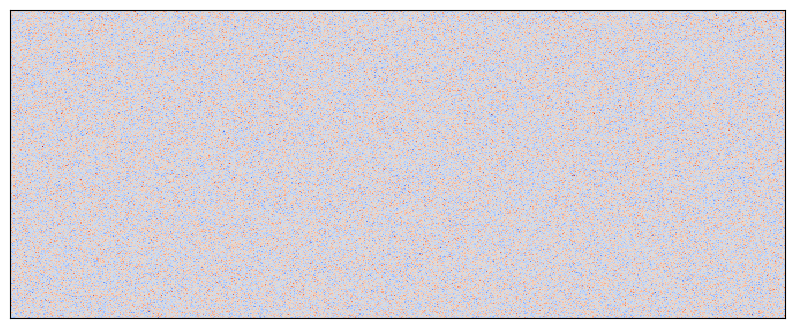

LibsndfileError: Error opening '../Results/test_00_out.wav': System error.

In [10]:
bwd_pass(model, noise_schedule, device, n_samples=1, file_name="test")
inference(model, file[11:12], noise_schedule, device=device, file_name="test")